Применим знания на практике: с помощью `pandahouse` попробуем выгрузить нужные данные из ClickHouse и проанализируем их в python. 

На этот раз новый датасет, содержащий информацию об объявлениях на Airbnb в Лондоне.

- ldn_listings – информация о жилье, включая полные описания, характеристики и средние оценки в отзывах; поскольку столбцов очень много, нужные перечислены в текстах самих задач

In [1]:
import pandas as pd
!pip install pandahouse
import pandahouse as ph
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
connection_default = {'host': 'http://clickhouse.beslan.pro:8080', 
                      'database':'default', 
                      'user':'student',  
                      'password':'dpo_python_2020' 
                     }

## 1
Для начала, проверим правильность подключения к ClickHouse через `pandahouse`, отправив простой запрос: выведите количество строк в таблице `ldn_listings`.

In [3]:
q1='''
SELECT count() as cnt_of_row from default.ldn_listings

'''
print(ph.read_clickhouse(q1,connection=connection_default ))

   cnt_of_row
0       85207


## 2
Выгрузите из таблицы данные о цене в зависимости от типа жилья. Необходимые столбцы:

`price` – цена за ночь
`room_type` – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)

Ограничение поставьте на 1000 строк. Результат должен быть отсортирован по возрастанию id.

Пример результирующей таблицы:
```
+-----------------+------------+
| room_type       | price      |
+-----------------+------------+
| Private room    |         65 | 
| Entire home/apt |        100 | 
+-----------------+------------+
```
Hint: replaceRegexpAll(столбец, что_заменить, на_что_заменить) – паттерн `[$,]` чтобы избавиться от `$` и запятых; toFloat32OrNull(столбец)

Сгруппируйте полученный датафрейм по типу жилья и посчитайте 75-й перцентиль цены.

В качестве ответа впишите полученное значение 75 перцентиля цены для комнат типа Private room.

In [4]:
q_price_vs_room_type = '''
SELECT
    id,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
    room_type
FROM
    ldn_listings
    
ORDER BY
    id

LIMIT 1000
'''

In [5]:
df_room_type=ph.read_clickhouse(q_price_vs_room_type,connection=connection_default)

In [6]:
df_room_type.head()

id  price        room_type
0  13913   65.0     Private room
1  15400  100.0  Entire home/apt
2  17402  300.0  Entire home/apt
3  17506  150.0     Private room
4  25023   65.0  Entire home/apt

In [7]:
df_room_type.groupby('room_type').price.quantile(q=0.75)

room_type
Entire home/apt    160.00
Hotel room         157.00
Private room        70.00
Shared room         69.25
Name: price, dtype: float64

In [8]:
df_room_type.query('room_type=="Private room"').price.quantile(q=0.75)

70.0

75-й перцкнтиль цены за ночь для Private room равен 70, это значит что 75% цены меньше 70 dollars , a 25% больше  70 dollars

## 3
К данным о цене и типе комнаты дополнительно выгрузите данные о рейтинге жилья (`review_scores_rating`). В запросе необходимо будет отфильтровать пустые значения `review_scores_rating` и сконвертировать эту колонку в тип `float32`.

Hint: `toFloat32OrNull(столбец)`

Давайте построим график рассеивания, который покажет зависимость средней цены от средней оценки в зависимости от типа жилья.

Исходная таблица должна выглядеть так:
```
+-----------------+------------+--------------------+
| room_type       | price      |review_scores_rating|
+-----------------+------------+--------------------+
| Private room    |         65 | 96.0               |
| Entire home/apt |        100 | 78.0               |
+-----------------+------------+--------------------+
```
1) сгруппируйте датафрейм по типу жилья и посчитайте среднее для цены и рейтинга (не забудьте привести рейтинг к типу float)

2) используйте sns.scatterplot, чтобы построить график рассеивания средней цены (ось X) и рейтинга (ось Y) c разбивкой по типу жилья (параметр hue)

In [9]:
q3='''

SELECT 
            id, 
            room_type, 
            toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price ,
            toFloat32OrNull(review_scores_rating) AS review_scores_rating  
from default.ldn_listings
WHERE review_scores_rating is not null
order by id 
limit 1000
'''

df3=ph.read_clickhouse(q3,connection=connection_default)

In [10]:
df3

id        room_type  price  review_scores_rating
0     13913     Private room   65.0                  97.0
1     15400  Entire home/apt  100.0                  96.0
2     17402  Entire home/apt  300.0                  94.0
3     25023  Entire home/apt   65.0                  93.0
4     25123     Private room   29.0                  96.0
..      ...              ...    ...                   ...
995  616278  Entire home/apt  165.0                 100.0
996  617678     Private room   99.0                  93.0
997  618082     Private room   45.0                 100.0
998  619010     Private room   20.0                  88.0
999  619890  Entire home/apt  100.0                  90.0

[1000 rows x 4 columns]

In [11]:
df3.room_type.value_counts()

Private room       509
Entire home/apt    487
Hotel room           2
Shared room          2
Name: room_type, dtype: int64

In [12]:
df3.dtypes

id                       uint32
room_type                object
price                   float32
review_scores_rating    float32
dtype: object

In [13]:
df3_mean=df3.groupby('room_type',as_index=False).agg({'price':'mean','review_scores_rating':'mean'})

In [14]:
df3_mean

room_type       price  review_scores_rating
0  Entire home/apt  135.882950             93.568787
1       Hotel room  134.000000             92.500000
2     Private room   54.642437             94.766205
3      Shared room   21.000000             90.000000

<AxesSubplot:xlabel='price', ylabel='review_scores_rating'>

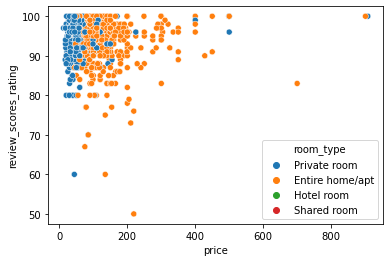

In [15]:
sns.scatterplot(x='price',
    y='review_scores_rating',
    hue='room_type',
    
    data=df3)

<AxesSubplot:xlabel='price', ylabel='review_scores_rating'>

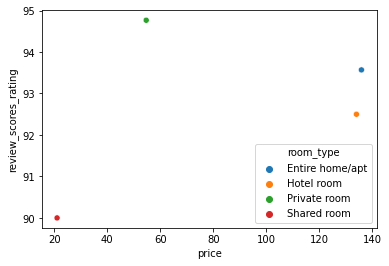

In [16]:
sns.scatterplot(x='price',
    y='review_scores_rating',
    hue='room_type',
    
    data=df3_mean)

##  4
Итак, помимо аренды жилья, на Airbnb также есть "Впечатления" — мероприятия, которые организуют местные жители.

Проверим, какие способы верификации аккаунта использовали хозяева, предлагающие различные впечатления (experiences_offered != 'none'). Для каждого уникального пользователя выгрузите только две колонки:

`host_id` – идентификатор хозяина (уникальный)  
`host_verifications` – какими способами хост подтвердил свой профиль  

Затем обработайте столбец host_verifications:

1. В ячейках находятся строковые представления списка (например, как результат `str([1, 2, 3]))`. Приведите их к настоящему списку, где в качестве элементов будут храниться использованные способы подтверждения аккаунта: 
`"['email', 'phone', 'facebook']" -> ['email', 'phone', 'facebook']`

2. Используйте методы `explode` и `value_counts`, чтобы посчитать, сколько раз встречается каждый способ верификации

Сколько хозяев подтвердили профиль с помощью аккаунта Google?

In [17]:
q4='''
SELECT 
          distinct  host_id,
          host_verifications
from default.ldn_listings
WHERE experiences_offered != 'none' 
'''

df4=ph.read_clickhouse(q4,connection=connection_default)

In [18]:
df4.host_verifications

0       ['email', 'phone', 'facebook', 'reviews', 'off...
1       ['email', 'phone', 'reviews', 'jumio', 'govern...
2       ['email', 'phone', 'jumio', 'selfie', 'governm...
3       ['email', 'phone', 'manual_offline', 'jumio', ...
4       ['email', 'phone', 'reviews', 'offline_governm...
                              ...                        
1356    ['email', 'phone', 'reviews', 'jumio', 'govern...
1357    ['email', 'phone', 'reviews', 'jumio', 'offlin...
1358    ['email', 'phone', 'reviews', 'jumio', 'govern...
1359    ['email', 'phone', 'google', 'reviews', 'jumio...
1360    ['email', 'phone', 'reviews', 'manual_offline'...
Name: host_verifications, Length: 1361, dtype: object

In [19]:
# считаем сколько раз встречается способ авторизации google (способ №1)
(
    df4
        .loc[df4.host_verifications.str.contains('google')] # отбираем строки где содержится google
        .host_verifications                                         # выбираем столбец для полсчёта значений
        .count()                                                    # считаем
)

34

In [20]:
s="['email', 'phone', 'reviews', 'manual_offline']"
print(s)
print(s.replace(' ', ''))
print(s.replace(' ', '').replace("'",''))
print(s.replace(' ', '').replace("'",'').strip('[]'))
print(s.replace(' ', '').replace("'",'').strip('[]').split(','))

['email', 'phone', 'reviews', 'manual_offline']
['email','phone','reviews','manual_offline']
[email,phone,reviews,manual_offline]
email,phone,reviews,manual_offline
['email', 'phone', 'reviews', 'manual_offline']


In [21]:
# переводим строковые данные колонки host_verifications в списоки
df4['host_verifications'] =  \
df4.host_verifications \
            .str. replace(' ', '') \
            .str.replace("'",'') \
            .str.strip('[]') \
            .str.split(',')

In [22]:
df4

host_id                                 host_verifications
0        54730  [email, phone, facebook, reviews, offline_gove...
1        60302      [email, phone, reviews, jumio, government_id]
2        67915  [email, phone, jumio, selfie, government_id, i...
3       167107  [email, phone, manual_offline, jumio, offline_...
4       103583  [email, phone, reviews, offline_government_id,...
...        ...                                                ...
1356  21558962      [email, phone, reviews, jumio, government_id]
1357  21257846  [email, phone, reviews, jumio, offline_governm...
1358  34219613      [email, phone, reviews, jumio, government_id]
1359  34299581  [email, phone, google, reviews, jumio, offline...
1360  26917573  [email, phone, reviews, manual_offline, jumio,...

[1361 rows x 2 columns]

In [23]:
df4.host_verifications.explode('host_verifications').value_counts()

phone                    1361
email                    1345
reviews                  1309
government_id            1196
jumio                    1115
offline_government_id     469
work_email                279
facebook                  270
selfie                    252
identity_manual           227
manual_offline             70
google                     34
kba                        27
manual_online              16
sent_id                     6
Name: host_verifications, dtype: int64

34 хозяина подтвердили номер в помощью гугла.

## 5
Теперь посмотрим, для скольких объявлений и в каких районах хозяева указали впечатления. Сгруппируйте данные по району и виду впечатления и посчитайте количество объявлений. Новый столбец назовите `experiences_count`.

Пример трёх строк результирующей таблицы: в районе City of London для 7 объявлений указан тип впечатления business, для одного – `family`.
```
+------------------------+---------------------+-------------------+
| neighbourhood_cleansed | experiences_offered | experiences_count |
+------------------------+---------------------+-------------------+
| City of London         | business            |                 7 |
| City of London         | family              |                 1 |
| City of London         | romantic            |                 1 |
+------------------------+---------------------+-------------------+
```
Отсортируйте данные по убыванию `experiences_count` и выгрузите первые 100 строк. Затем преобразуйте данные с помощью `pivot`, поместив в индексы название района, столбцы – вид впечатления, а значения – число объявлений с таким впечатлением для каждого района. Визуализируйте результат с помощью `sns.heatmap()` c палитрой `cmap=sns.cubehelix_palette(as_cmap=True)`. 

Какой график получился?

In [25]:
q5='''
SELECT 
         neighbourhood_cleansed,
         experiences_offered,
         count(*) as experiences_count
from default.ldn_listings
WHERE experiences_offered!='none'
group by  neighbourhood_cleansed,
         experiences_offered
order by experiences_count desc
limit 100
'''

df5=ph.read_clickhouse(q5,connection=connection_default)

In [26]:
df5

neighbourhood_cleansed experiences_offered  experiences_count
0                  Hackney              family                 61
1            Tower Hamlets            business                 58
2              Westminster            business                 50
3                  Hackney              social                 49
4   Hammersmith and Fulham            business                 48
..                     ...                 ...                ...
95               Redbridge              social                  2
96    Barking and Dagenham              social                  2
97                  Newham            romantic                  1
98                  Bexley            business                  1
99          City of London              family                  1

[100 rows x 3 columns]

In [37]:
df5_pivot=df5.pivot(index='neighbourhood_cleansed', columns='experiences_offered', values='experiences_count')

In [38]:
df5_pivot

experiences_offered     business  family  romantic  social
neighbourhood_cleansed                                    
Barking and Dagenham         NaN     NaN       NaN     2.0
Barnet                       7.0     7.0       3.0     5.0
Bexley                       1.0     NaN       NaN     NaN
Brent                        9.0    21.0       5.0     6.0
Bromley                      3.0     2.0       NaN     4.0
Camden                      36.0    30.0      19.0    25.0
City of London               7.0     1.0       NaN     NaN
Croydon                      2.0     3.0       NaN     4.0
Ealing                       6.0    13.0       NaN     5.0
Enfield                      3.0     NaN       NaN     2.0
Greenwich                    9.0     4.0       NaN     5.0
Hackney                     44.0    61.0      25.0    49.0
Hammersmith and Fulham      48.0    28.0       8.0    22.0
Haringey                    12.0    21.0       4.0    11.0
Harrow                       3.0     NaN       NaN     3.0
Hounslow                     6.0     8.0       NaN     2.0
Islington                   41.0    44.0      20.0    26.0
Kensington and Chelsea      37.0    32.0      30.0    13.0
Kingston upon Thames         3.0     4.0       NaN     NaN
Lambeth                     36.0    25.0      11.0    41.0
Lewisham                    11.0    16.0       2.0    10.0
Merton                       3.0     4.0       2.0     3.0
Newham                       9.0     9.0       1.0     9.0
Redbridge                    3.0     5.0       NaN     2.0
Richmond upon Thames        10.0     7.0       2.0     5.0
Southwark                   24.0    21.0       9.0    34.0
Sutton                       3.0     NaN       NaN     NaN
Tower Hamlets               58.0    16.0      13.0    46.0
Waltham Forest              14.0     4.0       NaN    12.0
Wandsworth                  23.0    24.0      13.0    13.0
Westminster                 50.0    37.0      23.0    18.0

In [56]:
cmap=sns.cubehelix_palette(as_cmap=True)
sns.set(rc = {'figure.figsize':(10,10)})

<AxesSubplot:xlabel='experiences_offered', ylabel='neighbourhood_cleansed'>

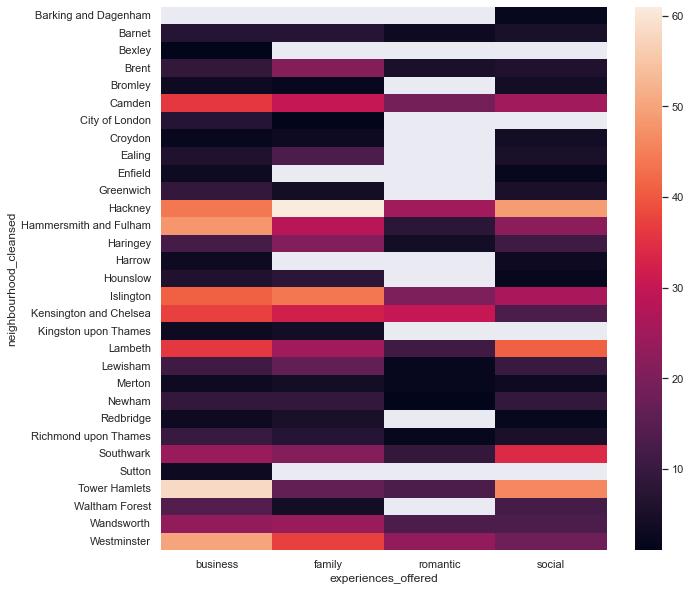

In [57]:
sns.heatmap(df5_pivot)

## 6
Выгрузите данные о ценах за ночь для разных типов жилья, для которых также доступен какой-либо вид впечатления. Необходимые для составления запроса столбцы:

`room_type` – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)  
`price` – цена за ночь 
`experiences_offered` – вид доступного впечатления (оставить не 'none')  

Пример части результирующей таблицы:
```
+-----------------+------------+
| room_type       | price_corr |
+-----------------+------------+
| Private room    |         65 |
| Entire home/apt |        100 |
| Entire home/apt |        ... |
+-----------------+------------+
```
Hint: `replaceRegexpAll(столбец, что_заменить, на_что_заменить)` – паттерн `[$,]` чтобы избавиться от `$` и запятых; `toFloat32OrNull(столбец)`

Далее постройте два графика, используя `distplot` из библиотеки seaborn:

На первом отобразите исходные распределения цен для каждого типа жилья
На втором – логарифмированные значения (np.log())

In [45]:
q6='''
SELECT 
         room_type,
         toFloat32OrNull(replaceRegexpAll(price, '[$,]','')) as price
from default.ldn_listings 
WHERE experiences_offered!='none'
'''
df6=ph.read_clickhouse(q6,connection=connection_default)

In [46]:
df6

room_type  price
0        Private room   65.0
1     Entire home/apt  100.0
2        Private room  150.0
3        Private room   45.0
4        Private room   25.0
...               ...    ...
1543  Entire home/apt  100.0
1544  Entire home/apt  125.0
1545  Entire home/apt  185.0
1546  Entire home/apt  110.0
1547     Private room   39.0

[1548 rows x 2 columns]

<AxesSubplot:xlabel='price', ylabel='Count'>

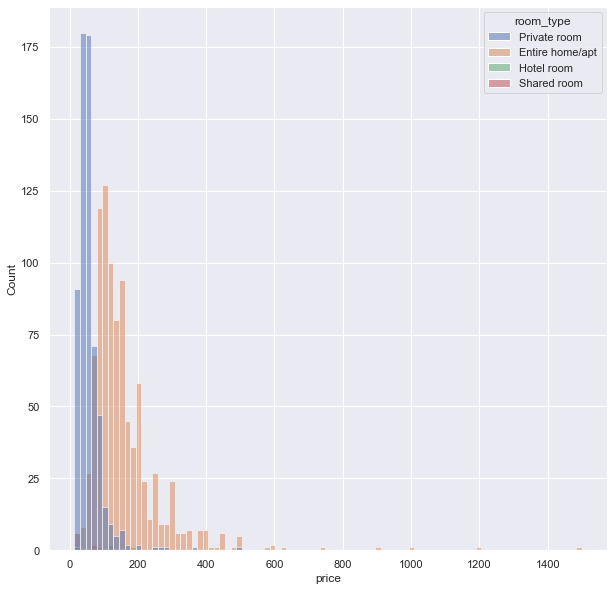

In [58]:
sns.histplot(data=df6, x='price', hue='room_type')

In [53]:
df6['log_price']=df6['price'].apply(lambda x: np.log10(x) )

In [54]:
df6

room_type  price  log_price
0        Private room   65.0   1.812913
1     Entire home/apt  100.0   2.000000
2        Private room  150.0   2.176091
3        Private room   45.0   1.653213
4        Private room   25.0   1.397940
...               ...    ...        ...
1543  Entire home/apt  100.0   2.000000
1544  Entire home/apt  125.0   2.096910
1545  Entire home/apt  185.0   2.267172
1546  Entire home/apt  110.0   2.041393
1547     Private room   39.0   1.591065

[1548 rows x 3 columns]

<AxesSubplot:xlabel='log_price', ylabel='Count'>

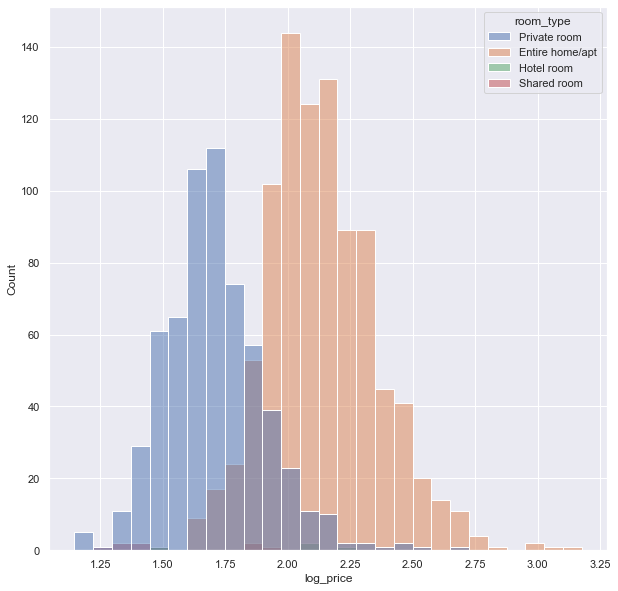

In [59]:
sns.histplot(data=df6, x='log_price', hue='room_type')

## 7
Выгрузите данные о цене, типе жилья и дате первого отзыва, начиная со 2 января 2010 года. Необходимые столбцы:

`room_type` – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)  
`price` – цена за ночь  
`first_review` – дата первого отзыва (отфильтровать по правилу "строго больше 2010-01-01")

Ограничение поставьте на 1000 строк.

Hint: `replaceRegexpAll(столбец, что_заменить, на_что_заменить)` – паттерн `[$,]` чтобы избавиться от `$` и запятых; `toFloat32OrNull(столбец)`

Пример результирующей таблицы:
```
+-----------------+------------+------------+
| room_type       | price_corr |first_review|
+-----------------+------------+------------+
| Private room    |         65 | 2010-03-23 |
| Entire home/apt |        100 | 2012-01-01 |
+-----------------+------------+------------+
```
Используя библиотеку seaborn и функцию `lineplot`, постройте график динамики средних цен на жилье (ось Y) в зависимости от типа комнаты (цвет линии, параметр 'hue') по годам (ось X). Датафрейм должен быть отсортирован по годам.

Пример датафрейма, который будет служить основой для графика:
```
+-----------------+------------+------------+
| room_type       | avg_price  | year       |
+-----------------+------------+------------+
| Private room    |         54 | 2010       |
| Entire home/apt |        168 | 2012       |
+-----------------+------------+------------+
```
Hints: `line plot`; удалите последние 6 символов у значений в столбце даты, чтобы получить год, например, с помощью применения lambda-функции .

In [85]:
q7='''

SELECT 
         room_type,
         toFloat32OrNull(replaceRegexpAll(price, '[$,]','')) as price,
         first_review
from default.ldn_listings 
WHERE experiences_offered!='none'  and  first_review > '2010-01-01'

limit 1000

'''
df7=ph.read_clickhouse(q7,connection=connection_default)

In [86]:
df7['first_review'] = pd.to_datetime(df7['first_review'])

In [87]:
df7['year']=df7['first_review'].dt.year.sort_values()

In [88]:
df7

room_type  price first_review  year
0       Private room   65.0   2010-08-18  2010
1       Private room   25.0   2010-09-15  2010
2       Private room   60.0   2010-08-01  2010
3    Entire home/apt  100.0   2012-08-07  2012
4       Private room   39.0   2010-09-25  2010
..               ...    ...          ...   ...
995  Entire home/apt  128.0   2014-09-15  2014
996  Entire home/apt  120.0   2014-12-29  2014
997  Entire home/apt  140.0   2014-12-31  2014
998  Entire home/apt  100.0   2014-09-21  2014
999     Private room   40.0   2014-12-15  2014

[1000 rows x 4 columns]

<AxesSubplot:xlabel='year', ylabel='price'>

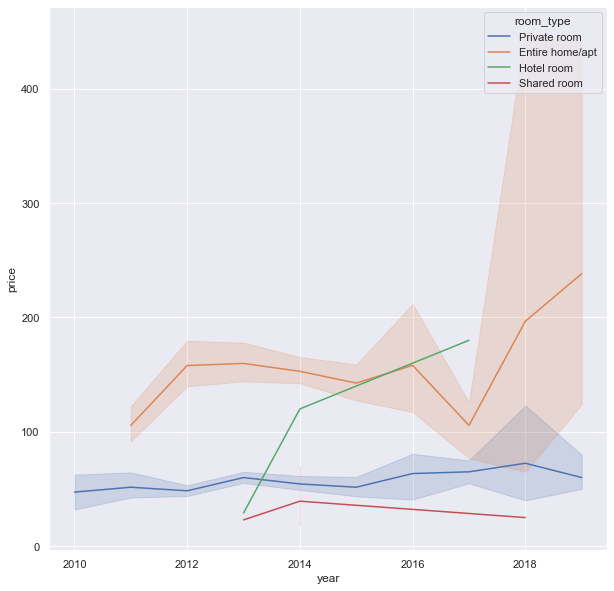

In [89]:
sns.lineplot(x='year',y='price',data=df7,hue='room_type')

In [93]:
df7_group = (
    df7
        .groupby(['year', 'room_type'], as_index=False)
        .agg({'price': 'mean'})
)


In [94]:
df7_group

year        room_type       price
0   2010     Private room   47.250000
1   2011  Entire home/apt  105.599998
2   2011     Private room   51.545456
3   2012  Entire home/apt  157.916672
4   2012     Private room   48.411766
5   2013  Entire home/apt  159.756104
6   2013       Hotel room   29.000000
7   2013     Private room   59.971962
8   2013      Shared room   23.000000
9   2014  Entire home/apt  152.860840
10  2014       Hotel room  120.000000
11  2014     Private room   54.410526
12  2014      Shared room   39.333332
13  2015  Entire home/apt  142.550003
14  2015     Private room   51.551723
15  2016  Entire home/apt  158.083328
16  2016     Private room   63.500000
17  2017  Entire home/apt  105.599998
18  2017       Hotel room  180.000000
19  2017     Private room   65.000000
20  2018  Entire home/apt  196.666672
21  2018     Private room   72.500000
22  2018      Shared room   25.000000
23  2019  Entire home/apt  238.199997
24  2019     Private room   60.000000

<AxesSubplot:xlabel='year', ylabel='price'>

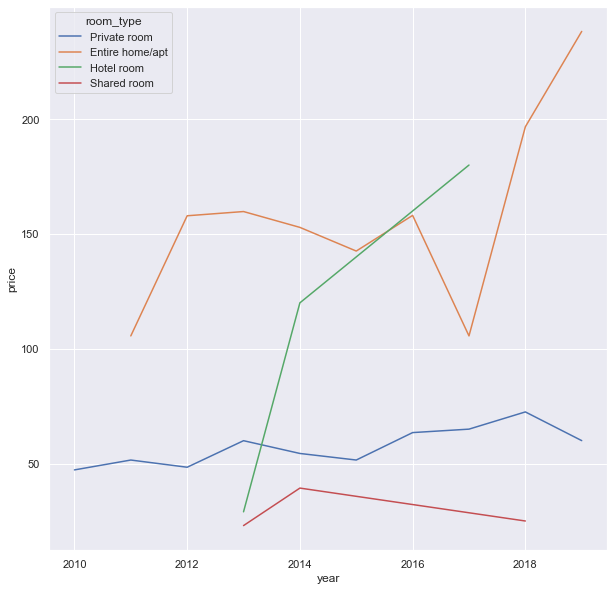

In [95]:
sns.lineplot(x='year',y='price',data=df7_group,hue='room_type')